<a href="https://colab.research.google.com/github/nksubramanian/Unit-Testing-/blob/main/InferenceSurgicalInstruments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Inference from a saved model

In [4]:
!pip install Pillow==8.4.0
# restart is required after this cell

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
!wget https://raw.githubusercontent.com/airctic/icevision/master/icevision_install.sh
!bash icevision_install.sh cuda11 master



--2022-10-30 00:28:21--  https://raw.githubusercontent.com/airctic/icevision/master/icevision_install.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2820 (2.8K) [text/plain]
Saving to: ‘icevision_install.sh.1’

icevision_install.s 100%[===================>]   2.75K  --.-KB/s    in 0s      

2022-10-30 00:28:22 (24.0 MB/s) - ‘icevision_install.sh.1’ saved [2820/2820]

Installing icevision + dependencices for cuda11
- Installing torch and its dependencies
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
- Installing mmcv
- Installing mmdet
- Installing mmseg
- Installing icevision from master
- Installing icedata from master
Looking in ind

In [7]:
import icevision
from icevision.all import *

ModuleNotFoundError: ignored

In [ ]:
# this might be required only when there is an error

print('icevision v',icevision.__version__)
print('torch v',torch.__version__)
print('torchvision v',torchvision.__version__)

icevision v 0.12.0
torch v 1.10.0+cu111
torchvision v 0.11.1+cu111


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)

Mounted at /content/gdrive


In [ ]:
root_dir = Path('/content/gdrive/My Drive/')

In [ ]:
classes = ['Army_navy', 'Bulldog', 'Castroviejo','Forceps', 'Frazier', 'Hemostat','Iris','Mayo_metz','Needle','Potts','Richardson','Scalpel','Towel_clip', 'Weitlaner','Yankauer']
class_map = ClassMap(classes)
len(class_map)

16

In [ ]:
metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]

from icevision.models.checkpoint import *

model_type = models.mmdet.vfnet ##
backbone = model_type.backbones.resnet50_fpn_mstrain_2x##

In [ ]:
!ls gdrive/MyDrive/Surgical_instruments/Models

notebooks  README.md  VFNet_teacher_nov29_mAP82.6.pth


In [ ]:
from icevision.models import *

checkpoint_path = root_dir/'Surgical_instruments/Models/VFNet_teacher_nov29_mAP82.6.pth' 

checkpoint_and_model = model_from_checkpoint(checkpoint_path)

model_loaded = checkpoint_and_model["model"]

load checkpoint from local path: /content/gdrive/My Drive/Surgical_instruments/Models/VFNet_teacher_nov29_mAP82.6.pth


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/builder.py:17: UserWarning: ``build_anchor_generator`` would be deprecated soon, please use ``build_prior_generator`` 
  '``build_anchor_generator`` would be deprecated soon, please use '
2022-10-29 05:42:54,478 - mmcv - INFO - initialize ResNet with init_cfg {'type': 'Pretrained', 'checkpoint': 'torchvision://resnet50'}
2022-10-29 05:42:54,479 - mmcv - INFO - load model from: torchvision://resnet50
2022-10-29 05:42:54,485 - mmcv - INFO - load checkpoint from torchvision path: torchvision://resnet50
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

2022-10-29 05:42:55,419 - mmcv - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: fc.weight, fc.bias

2022-10-29 05:42:55,449 - mmcv - INFO - initialize FPN with init_cfg {'type': 'Xavier', 'layer': 'Conv2d', 'distribution': 'uniform'}
2022-10-29 05:42:55,479 - mmcv - INFO - initialize VFNetHead with init_cfg {'type': 'Normal', 'layer': 'Conv2d', 'std': 0.01, 'override': {'type': 'Normal', 'name': 'vfnet_cls', 'std': 0.01, 'bias_prob': 0.01}}
2022-10-29 05:42:55,517 - mmcv - INFO - 
backbone.conv1.weight - torch.Size([64, 3, 7, 7]): 
PretrainedInit: load from torchvision://resnet50 
 
2022-10-29 05:42:55,519 - mmcv - INFO - 
backbone.bn1.weight - torch.Size([64]): 
PretrainedInit: load from torchvision://resnet50 
 
2022-10-29 05:42:55,522 - mmcv - INFO - 
backbone.bn1.bias - torch.Size([64]): 
PretrainedInit: load from torchvision://resnet50 
 
2022-10-29 05:42:55,525 - mmcv - INFO - 
backbone.layer1.0.conv1.weight - torch.Size([64, 

In [ ]:
img_size = checkpoint_and_model["img_size"]

valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(img_size), tfms.A.Normalize()])

#infer_ds = Dataset.from_images(imgs_array, valid_tfms, class_map = class_map)
#infer_ds = Dataset(test_records, valid_tfms)#, class_map = class_map)

Gradio deployment using saved model

In [ ]:
# wont be necessary
!echo "- Installing gradio"
!pip install gradio -U -q
import icedata
import PIL, requests
import torch
from torchvision import transforms
import gradio as gr

def show_preds_gradio(input_image, display_label, display_bbox, detection_threshold):

    if detection_threshold==0: detection_threshold=0.5

    img = PIL.Image.fromarray(input_image, 'RGB')

    pred_dict  = model_type.end2end_detect(img, 
                                           valid_tfms, 
                                           model_loaded, ## 
                                           class_map=class_map, 
                                           detection_threshold=detection_threshold,
                                           display_label=display_label, 
                                           display_bbox=display_bbox, 
                                           return_img=True, 
                                           font_size=16, 
                                           label_color="#FF59D6")

    return pred_dict['img']

- Installing gradio
     |████████████████████████████████| 11.6 MB 25.2 MB/s 
     |████████████████████████████████| 272 kB 74.7 MB/s 
     |████████████████████████████████| 2.3 MB 65.1 MB/s 
     |████████████████████████████████| 56 kB 4.6 MB/s 
     |████████████████████████████████| 212 kB 72.6 MB/s 
     |████████████████████████████████| 54 kB 3.3 MB/s 
     |████████████████████████████████| 106 kB 70.9 MB/s 
     |████████████████████████████████| 84 kB 3.5 MB/s 
     |████████████████████████████████| 55 kB 3.7 MB/s 
     |████████████████████████████████| 84 kB 3.3 MB/s 
     |████████████████████████████████| 63 kB 2.1 MB/s 
     |████████████████████████████████| 80 kB 10.0 MB/s 
     |████████████████████████████████| 68 kB 7.5 MB/s 
     |████████████████████████████████| 46 kB 4.2 MB/s 
     |████████████████████████████████| 856 kB 71.9 MB/s 
     |████████████████████████████████| 4.0 MB 64.0 MB/s 
     |████████████████████████████████| 593 kB 72.8 MB/s 


In [ ]:
#wont be necessary
display_chkbox_label = gr.inputs.Checkbox(label="Label", default=True)
display_chkbox_box = gr.inputs.Checkbox(label="Box", default=True)

detection_threshold_slider = gr.inputs.Slider(minimum=0, maximum=1, step=0.1, default=0.5, label="Detection Threshold")

outputs = gr.outputs.Image()

# Option 1: Get an image from local drive

gr_interface = gr.Interface(fn=show_preds_gradio, inputs=["image", display_chkbox_label, display_chkbox_box,  detection_threshold_slider], outputs=outputs, title='IceApp - COCO')

/usr/local/lib/python3.7/dist-packages/gradio/inputs.py:121: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  "Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components",
/usr/local/lib/python3.7/dist-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
/usr/local/lib/python3.7/dist-packages/gradio/inputs.py:89: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  "Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components",
/usr/local/lib/python3.7/dist-packages/gradio/outputs.py:43: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please 

In [ ]:
#wont be necessary
gr_interface.launch(inline=False, share=True, debug=True)


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().


KeyboardInterrupt: ignored

In [ ]:
#wont be necessary
display_chkbox_label = gr.inputs.Checkbox(label="Label", default=True)
display_chkbox_box = gr.inputs.Checkbox(label="Box", default=True)
t = show_preds_gradio(img,display_chkbox_label, display_chkbox_box, 0.5 )

In [ ]:
path = Path('gdrive/MyDrive/Surgical_instruments/Sets/Second_set') # 

test_parser = parsers.COCOBBoxParser(
    annotations_filepath = path/'test/_annotations.coco.json',
    img_dir = path/'test')

whole = SingleSplitSplitter()

test_records, *_ = test_parser.parse(data_splitter = whole)

  0%|          | 0/1 [00:00<?, ?it/s]

INFO     - Autofixing records | icevision.parsers.parser:parse:122


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
img_size = checkpoint_and_model["img_size"]

valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(img_size), tfms.A.Normalize()])

#infer_ds = Dataset.from_images(imgs_array, valid_tfms, class_map = class_map)
#, class_map = class_map)

In [ ]:
infer_ds = Dataset(test_records, valid_tfms)
infer_dl = model_type.infer_dl(infer_ds, 
                               batch_size=1, shuffle=False)

preds_saved_test = model_type.predict_from_dl(model_loaded,#
                                              infer_dl,
                                          keep_images=True, 
                                         detection_threshold = 0.5) ##

  0%|          | 0/1 [00:00<?, ?it/s]

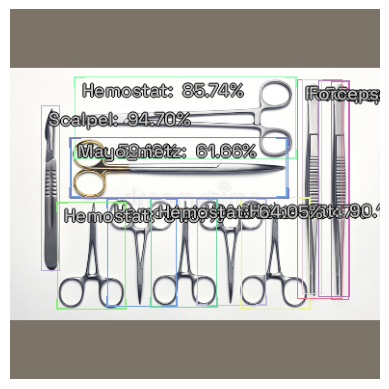

BaseRecord

common: 
	- Image size ImgSize(width=384, height=384)
	- Record ID: 0
	- Img: 384x384x3 <np.ndarray> Image
detection: 
	- BBoxes: [<BBox (xmin:333.1064758300781, ymin:75.0309066772461, xmax:351.0039367675781, ymax:301.0577697753906)>, <BBox (xmin:320.193603515625, ymin:74.44438171386719, xmax:352.89337158203125, ymax:298.9892578125)>, <BBox (xmin:298.7884521484375, ymin:73.6069564819336, xmax:344.47943115234375, ymax:300.22430419921875)>, <BBox (xmin:303.18792724609375, ymin:73.35259246826172, xmax:323.38519287109375, ymax:295.1640930175781)>, <BBox (xmin:194.8096160888672, ymin:196.71556091308594, xmax:265.6084289550781, ymax:307.9135437011719)>, <BBox (xmin:101.00445556640625, ymin:196.120849609375, xmax:172.49900817871094, ymax:308.29071044921875)>, <BBox (xmin:49.17043685913086, ymin:200.80111694335938, xmax:119.70035552978516, ymax:311.455078125)>, <BBox (xmin:240.95950317382812, ymin:195.68661499023438, xmax:310.79644775390625, ymax:311.3856506347656)>, <BBox (xmin:67

In [ ]:
a=0
show_sample(preds_saved_test[a])
preds_saved_test[a].pred